<a href="https://colab.research.google.com/github/Alejandra-Montenegro/tarea-redes-neuronales-Grupo6/blob/main/Proyecto3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===== PASO 0: ruta del ZIP y listado =====
from pathlib import Path
import zipfile

ZIP_PATH = Path("/content/GRUPO7 PROY 3.zip")  # ← AJUSTADO a tu ruta
print("ZIP:", ZIP_PATH)
assert ZIP_PATH.exists(), f"No existe el ZIP en {ZIP_PATH}"

with zipfile.ZipFile(ZIP_PATH, "r") as zf:
    MEMBERS = zf.namelist()

print("Archivos en el ZIP:")
for m in MEMBERS:
    print(" -", m)


ZIP: /content/GRUPO7 PROY 3.zip
Archivos en el ZIP:
 - genome_scores.csv
 - genome_tags.csv
 - link.csv
 - movie.csv
 - rating.csv
 - tag.csv


In [ ]:
# ===== PASO 1: funciones de lectura robusta desde el ZIP =====
import io
import pandas as pd
from typing import List, Optional
import re

def find_member(members: List[str], patterns: List[str]) -> Optional[str]:
    """Devuelve el primer miembro cuyo nombre (sin carpeta) matchea alguno de los patrones."""
    pats = [p.lower() for p in patterns]
    for m in members:
        name = m.split("/")[-1].lower()
        if name in pats:
            return m
    return None

def read_csv_member(zip_path: Path, member: str, encodings=("utf-8","utf-8-sig","latin-1","cp1252")) -> pd.DataFrame:
    with zipfile.ZipFile(zip_path, "r") as zf:
        raw = zf.read(member)
    last = None
    for enc in encodings:
        try:
            df = pd.read_csv(io.BytesIO(raw), encoding=enc, sep=",", header=0,
                             on_bad_lines="skip", engine="python") # Removed low_memory=False
            return df
        except Exception as e:
            last = e
    raise RuntimeError(f"No pude leer {member} con encodings comunes. Último error: {repr(last)}")

In [ ]:
# ===== PASO 2.5: Cargar movie.csv =====
# Usar la función read_csv_member para cargar movie.csv
# Primero, encontrar el nombre exacto del miembro
movie_member = find_member(MEMBERS, ["movie.csv"])

if movie_member:
    print(f"Cargando {movie_member}...")
    df_movies = read_csv_member(ZIP_PATH, movie_member)
    print("df_movies cargado con éxito.")
    print(df_movies.head())
else:
    raise FileNotFoundError("No se encontró 'movie.csv' en el ZIP.")

# Cargar tag.csv si existe para el enriquecimiento opcional en PASO 3
tag_member = find_member(MEMBERS, ["tag.csv"])
df_tags = None # Inicializar df_tags a None
if tag_member:
    print(f"\nCargando {tag_member} para enriquecimiento...")
    try:
        df_tags = read_csv_member(ZIP_PATH, tag_member)
        print("df_tags cargado con éxito.")
        print(df_tags.head())
    except Exception as e:
        print(f"Error al cargar {tag_member}: {e}")
else:
    print("\n'tag.csv' no encontrado en el ZIP. El enriquecimiento con tags no se realizará.")

Cargando movie.csv...
df_movies cargado con éxito.
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Cargando tag.csv para enriquecimiento...
df_tags cargado con éxito.
   userId  movieId            tag            timestamp
0      18     4141    Mark Waters  2009-04-24 18:19:40
1      65      208      dark hero  2013-05-10 01:41:18
2      65      353      dark hero  2013-05-10 01:41:19
3      65      521  noir thriller  2013-05-10 01:39:43
4      65 

In [ ]:
# ===== PASO 3: base (movie_id, title, year) + enriquecimiento con tags =====
import numpy as np

# Normalizar nombres esperados
if "movieId" not in df_movies.columns:
    # intenta variantes raras
    for c in df_movies.columns:
        if c.lower() == "movieid":
            df_movies = df_movies.rename(columns={c: "movieId"})
            break

assert "movieId" in df_movies.columns, "El archivo movie.csv debe traer 'movieId'."
assert "title"   in df_movies.columns, "El archivo movie.csv debe traer 'title'."

# Año desde el título "(YYYY)" al final (formato MovieLens)
year_pat = re.compile(r"\((\d{4})\)\s*$")
def extract_year(title: str):
    if not isinstance(title, str): return np.nan
    m = year_pat.search(title.strip())
    if not m: return np.nan
    try:
        return int(m.group(1))
    except:
        return np.nan

base = df_movies.copy()
base["movie_id"] = pd.to_numeric(base["movieId"], errors="coerce")
base["year"] = base["title"].apply(extract_year)
base = base[["movie_id","title","year"]].copy()

# Enriquecer con tags (opcional): concatenar los tags por movie_id
if df_tags is not None and "movieId" in df_tags.columns and "tag" in df_tags.columns:
    tt = df_tags[["movieId","tag"]].dropna()
    # puede haber MUCHOS tags duplicados; nos quedamos con únicos por película
    agg = tt.groupby("movieId")["tag"].apply(lambda s: " ".join(sorted(set(map(str, s)))))
    agg = agg.rename("tags_text").reset_index()
    agg["movie_id"] = pd.to_numeric(agg["movieId"], errors="coerce")
    base = base.merge(agg[["movie_id","tags_text"]], on="movie_id", how="left")
    base["title_plus"] = base["title"].fillna("") + " " + base["tags_text"].fillna("")
else:
    base["title_plus"] = base["title"].fillna("")

print("Base shape:", base.shape)
print(base.head(10).to_string(index=False))

print("\nFaltantes:")
print(base.isna().sum())


Base shape: (27275, 5)
 movie_id                              title   year                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [ ]:
# ===== PASO 4: década + filtrado =====
MIN_YEAR, MAX_YEAR = 1870, 2035

df = base.copy()
df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["decade"] = (df["year"] // 10) * 10

ok = df["year"].between(MIN_YEAR, MAX_YEAR) & df["decade"].notna() & (df["title_plus"].astype(str).str.len() >= 2)
df_ok = df[ok].copy()
df_ok["decade"] = df_ok["decade"].astype(int)

print("Filas válidas:", len(df_ok), "de", len(df))
print("Décadas:", sorted(df_ok["decade"].unique().tolist()))
print("\nDistribución por década:")
print(df_ok["decade"].value_counts().sort_index().to_string())

print("\nMuestra:")
print(df_ok[["movie_id","title","year","decade"]].head(8).to_string(index=False))


Filas válidas: 27252 de 27275
Décadas: [1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

Distribución por década:
decade
1890      14
1900       8
1910      97
1920     319
1930     929
1940    1067
1950    1369
1960    1661
1970    2020
1980    2653
1990    4371
2000    7873
2010    4871

Muestra:
 movie_id                              title   year  decade
        1                   Toy Story (1995) 1995.0    1990
        2                     Jumanji (1995) 1995.0    1990
        3            Grumpier Old Men (1995) 1995.0    1990
        4           Waiting to Exhale (1995) 1995.0    1990
        5 Father of the Bride Part II (1995) 1995.0    1990
        6                        Heat (1995) 1995.0    1990
        7                     Sabrina (1995) 1995.0    1990
        8                Tom and Huck (1995) 1995.0    1990


In [ ]:
# ===== PASO 5: BoW binario =====
import re
from collections import Counter
import numpy as np
import pandas as pd # Ensure pandas is imported

TEXT_COL = "title_plus"  # usa el enriquecido si existe
TOKEN_RE = re.compile(r"[a-z0-9áéíóúñü]+" , re.IGNORECASE)

def tok_words(s):
    s = "" if pd.isna(s) else str(s).lower()
    return TOKEN_RE.findall(s)

def char_ngrams(s, n=3):
    s = "" if pd.isna(s) else str(s).lower().strip()
    s = re.sub(r"\s+", " ", s)
    return [s[i:i+n] for i in range(max(0, len(s)-n+1))]

VOCAB_SIZE = 2000  # puedes ajustar (1000/3000)

def build_vocab(texts, mode="word", k=VOCAB_SIZE):
    cnt = Counter()
    if mode == "word":
        for t in texts: cnt.update(tok_words(t))
    else:
        for t in texts: cnt.update(char_ngrams(t, 3))

    # Add a print statement to inspect items before unpacking
    print(f"Inspecting first {min(k, 20)} items from most_common:") # Print first few items
    mc_result = cnt.most_common(k)
    for i, item in enumerate(mc_result[:min(k, 20)]):
        print(f"  Item {i}: {item} (type: {type(item)})")

    return {w:i for i,(w,_) in enumerate(mc_result)} # Corrected unpacking syntax

vocab = build_vocab(df_ok[TEXT_COL].tolist(), mode="word", k=VOCAB_SIZE)
use_char = False
if len(vocab) < 20:
    print("⚠️ Vocab de palabras insuficiente; activando 3-gramas de caracteres…")
    vocab = build_vocab(df_ok[TEXT_COL].tolist(), mode="char", k=VOCAB_SIZE)
    use_char = True

print("Vocab size:", len(vocab), "| Top-10:", list(vocab.keys())[:10])
assert len(vocab) > 0, "No se pudo construir vocabulario; revisa contenido de títulos/tags."

def vectorize(text):
    v = np.zeros(len(vocab), dtype=np.float32)
    toks = set(char_ngrams(text,3)) if use_char else set(tok_words(text))
    for tok in toks:
        idx = vocab.get(tok)
        if idx is not None:
            v[idx] = 1.0
    return v

X = np.vstack([vectorize(t) for t in df_ok[TEXT_COL].tolist()])
decades = sorted(df_ok["decade"].unique().tolist())
dec_to_idx = {d:i for i,d in enumerate(decades)}
idx_to_dec = {i:d for d,i in dec_to_idx.items()}
y = np.array([dec_to_idx[d] for d in df_ok["decade"].tolist()], dtype=np.int64)

print("X:", X.shape, "| y:", y.shape, "| clases:", len(decades), "| décadas:", decades)
assert len(decades) >= 2, "Se necesitan al menos 2 décadas distintas para clasificar."

Inspecting first 20 items from most_common:
  Item 0: ('the', 11682) (type: <class 'tuple'>)
  Item 1: ('a', 5109) (type: <class 'tuple'>)
  Item 2: ('of', 4884) (type: <class 'tuple'>)
  Item 3: ('s', 4435) (type: <class 'tuple'>)
  Item 4: ('r', 3716) (type: <class 'tuple'>)
  Item 5: ('nudity', 3571) (type: <class 'tuple'>)
  Item 6: ('on', 3354) (type: <class 'tuple'>)
  Item 7: ('to', 3101) (type: <class 'tuple'>)
  Item 8: ('bd', 2743) (type: <class 'tuple'>)
  Item 9: ('book', 2488) (type: <class 'tuple'>)
  Item 10: ('movie', 2337) (type: <class 'tuple'>)
  Item 11: ('dvd', 2302) (type: <class 'tuple'>)
  Item 12: ('topless', 2294) (type: <class 'tuple'>)
  Item 13: ('based', 2252) (type: <class 'tuple'>)
  Item 14: ('and', 2216) (type: <class 'tuple'>)
  Item 15: ('in', 1997) (type: <class 'tuple'>)
  Item 16: ('comedy', 1839) (type: <class 'tuple'>)
  Item 17: ('11', 1760) (type: <class 'tuple'>)
  Item 18: ('see', 1690) (type: <class 'tuple'>)
  Item 19: ('best', 1640) (type

In [ ]:
# ===== PASO 6: split =====
RNG = np.random.default_rng(42)

N = X.shape[0]
idx = np.arange(N); RNG.shuffle(idx)

train_ratio, val_ratio = (0.70, 0.15) if N >= 100 else (0.60, 0.20)
n_train = max(1, int(N*train_ratio))
n_val   = max(1, int(N*val_ratio))
if n_train + n_val >= N:
    n_val = max(1, n_val - 1)

train_idx = idx[:n_train]
val_idx   = idx[n_train:n_train+n_val]
test_idx  = idx[n_train+n_val:]

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print(f"Split -> train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")


Split -> train=19076, val=4087, test=4089


In [ ]:
# ===== PASO 7: NN desde cero =====
import numpy as np, math

def he_init(f_in,f_out,rng):     return rng.normal(0, (2/f_in)**0.5, size=(f_in,f_out)).astype(np.float32)
def xavier_init(f_in,f_out,rng): return rng.normal(0, (1/f_in)**0.5, size=(f_in,f_out)).astype(np.float32)
def zeros_bias(d):               return np.zeros((1,d), dtype=np.float32)

def relu(Z): return np.maximum(0,Z)
def drelu(Z): return (Z>0).astype(np.float32)
def sigmoid(Z): return 1/(1+np.exp(-Z))
def dsigmoid(A): return A*(1-A)
def tanh_fn(Z): return np.tanh(Z)
def dtanh(A): return 1 - A**2

def softmax(Z):
    Zs = Z - Z.max(axis=1, keepdims=True)
    e = np.exp(Zs)
    return e / e.sum(axis=1, keepdims=True)

def one_hot(y,K):
    Y = np.zeros((y.shape[0], K), dtype=np.float32)
    Y[np.arange(y.shape[0]), y] = 1.0
    return Y

class NeuralNetwork:
    def __init__(self, layers, activation='relu', init='he', seed=42):
        assert len(layers) >= 4, "Usa al menos input + 2 ocultas + salida."
        self.layers = layers
        self.act_name = activation.lower()
        self.init_name = init.lower()
        self.rng = np.random.default_rng(seed)

        if self.act_name=='relu':   self.act,self.dact = relu, drelu
        elif self.act_name=='sigmoid': self.act,self.dact = sigmoid, dsigmoid
        elif self.act_name=='tanh': self.act,self.dact = tanh_fn, dtanh
        else: raise ValueError("Activación no soportada.")

        self.params = {}
        for l in range(1,len(layers)):
            f_in,f_out = layers[l-1], layers[l]
            if l < len(layers)-1:
                W = he_init(f_in,f_out,self.rng) if self.init_name=='he' else xavier_init(f_in,f_out,self.rng)
            else:
                W = xavier_init(f_in,f_out,self.rng)
            b = zeros_bias(f_out)
            self.params[f"W{l}"], self.params[f"b{l}"] = W, b

    def forward(self, X):
        A = X; cache = {"A0":X}; L = len(self.layers)-1
        for l in range(1, L):
            Z = A @ self.params[f"W{l}"] + self.params[f"b{l}"]
            A = self.act(Z)
            cache[f"Z{l}"], cache[f"A{l}"] = Z, A
        ZL = A @ self.params[f"W{L}"] + self.params[f"b{L}"]
        AL = softmax(ZL)
        cache[f"Z{L}"], cache[f"A{L}"] = ZL, AL
        return AL, cache

    def compute_loss_and_grads(self, X, y):
        m = X.shape[0]; K = self.layers[-1]
        Y = one_hot(y, K)
        AL, cache = self.forward(X)
        eps = 1e-12
        loss = -np.sum(Y*np.log(AL+eps)) / m

        grads = {}; L = len(self.layers)-1
        dZ = (AL - Y) / m
        A_prev = cache[f"A{L-1}"]
        grads[f"dW{L}"] = A_prev.T @ dZ
        grads[f"db{L}"] = dZ.sum(axis=0, keepdims=True)
        dA_prev = dZ @ self.params[f"W{L}"].T

        for l in range(L-1, 0, -1):
            Zl, Al, A_prev = cache[f"Z{l}"], cache[f"A{l}"], cache[f"A{l-1}"]
            if self.act_name=='relu':    dZ = dA_prev * drelu(Zl)
            elif self.act_name=='sigmoid': dZ = dA_prev * dsigmoid(Al)
            else:                         dZ = dA_prev * dtanh(Al)
            grads[f"dW{l}"] = A_prev.T @ dZ
            grads[f"db{l}"] = dZ.sum(axis=0, keepdims=True)
            if l > 1: dA_prev = dZ @ self.params[f"W{l}"].T
        return loss, grads

    def update(self, grads, lr):
        for k in list(self.params.keys()):
            self.params[k] -= lr * grads["d"+k]

    def predict(self, X):
        return self.forward(X)[0].argmax(axis=1)

    def train(self, X_tr, y_tr, X_val=None, y_val=None, epochs=20, lr=0.05, batch=128, verbose=True):
        hist = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
        m = X_tr.shape[0]
        for ep in range(1, epochs+1):
            idx = np.arange(m); self.rng.shuffle(idx)
            Xs, ys = X_tr[idx], y_tr[idx]
            for st in range(0, m, batch):
                ed = st + batch
                xb, yb = Xs[st:ed], ys[st:ed]
                loss, grads = self.compute_loss_and_grads(xb, yb)
                self.update(grads, lr)
            tr_loss, _ = self.compute_loss_and_grads(X_tr, y_tr)
            ypt = self.predict(X_tr); tr_acc = (ypt==y_tr).mean()
            if X_val is not None:
                va_loss, _ = self.compute_loss_and_grads(X_val, y_val)
                ypv = self.predict(X_val); va_acc = (ypv==y_val).mean()
            else:
                va_loss = va_acc = math.nan
            hist["train_loss"].append(tr_loss); hist["val_loss"].append(va_loss)
            hist["train_acc"].append(tr_acc);  hist["val_acc"].append(va_acc)
            if verbose:
                print(f"Epoch {ep:02d} | train_loss={tr_loss:.4f} val_loss={va_loss:.4f} "
                      f"train_acc={tr_acc:.4f} val_acc={va_acc:.4f}")
        return hist

# Entrenamiento base
input_dim = X_train.shape[1]
num_classes = len(decades)
layers = [input_dim, 128, 64, num_classes]  # 2 ocultas

nn = NeuralNetwork(layers=layers, activation='relu', init='he', seed=42)
history = nn.train(X_train, y_train, X_val=X_val, y_val=y_val,
                   epochs=20, lr=0.05, batch=128, verbose=True)

y_pred_test = nn.predict(X_test)
test_acc = (y_pred_test == y_test).mean()
print("Accuracy en Test:", round(float(test_acc), 4))


Epoch 01 | train_loss=1.9735 val_loss=2.0090 train_acc=0.2915 val_acc=0.2811
Epoch 02 | train_loss=1.6275 val_loss=1.6722 train_acc=0.4896 val_acc=0.4842
Epoch 03 | train_loss=1.0444 val_loss=1.1013 train_acc=0.6924 val_acc=0.6714
Epoch 04 | train_loss=0.7439 val_loss=0.8025 train_acc=0.7943 val_acc=0.7666
Epoch 05 | train_loss=0.5870 val_loss=0.6426 train_acc=0.8399 val_acc=0.8187
Epoch 06 | train_loss=0.4661 val_loss=0.5179 train_acc=0.9164 val_acc=0.8980
Epoch 07 | train_loss=0.3602 val_loss=0.4079 train_acc=0.9385 val_acc=0.9273
Epoch 08 | train_loss=0.2980 val_loss=0.3446 train_acc=0.9282 val_acc=0.9173
Epoch 09 | train_loss=0.2064 val_loss=0.2438 train_acc=0.9738 val_acc=0.9670
Epoch 10 | train_loss=0.1592 val_loss=0.1948 train_acc=0.9780 val_acc=0.9701
Epoch 11 | train_loss=0.1345 val_loss=0.1671 train_acc=0.9816 val_acc=0.9748
Epoch 12 | train_loss=0.1031 val_loss=0.1322 train_acc=0.9843 val_acc=0.9790
Epoch 13 | train_loss=0.0863 val_loss=0.1131 train_acc=0.9866 val_acc=0.9807

In [ ]:
# ===== MÉTRICAS: accuracy + matriz de confusión =====
import numpy as np

def confusion_matrix_np(y_true, y_pred, n_classes):
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for t,p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

test_acc = (y_pred_test == y_test).mean()
print(f"Accuracy Test: {test_acc:.4f}")

cm = confusion_matrix_np(y_test, y_pred_test, n_classes=len(idx_to_dec))
print("\nMatriz de confusión (filas=verdadero, cols=predicho):")
print(cm)

# Mostrar etiquetas de década alineadas
dec_labels = [idx_to_dec[i] for i in range(len(idx_to_dec))]
print("\nEtiquetas (orden de filas/columnas):", dec_labels)


Accuracy Test: 0.9929

Matriz de confusión (filas=verdadero, cols=predicho):
[[   0    0    0    1    0    0    0    0    0    0    0    0    0]
 [   0    0    0    2    0    0    0    0    0    0    0    0    0]
 [   0    0    0   12    0    0    0    0    0    0    0    0    0]
 [   0    0    0   37    3    0    1    0    0    0    0    0    0]
 [   0    0    0    0  153    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0  158    0    0    0    0    0    0    0]
 [   0    0    0    0    0    1  187    0    0    0    0    1    0]
 [   0    0    0    0    0    0    0  247    0    0    2    0    0]
 [   0    0    0    0    0    0    0    1  287    0    1    0    0]
 [   0    0    0    0    0    0    0    0    0  393    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0  692    1    0]
 [   0    0    0    1    0    0    0    0    0    1    0 1161    1]
 [   0    0    0    0    0    0    0    0    0    0    0    0  745]]

Etiquetas (orden de filas/columnas): 

In [ ]:
# ===== BASELINE A: LogisticRegression (si tienes scikit-learn) =====
try:
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score

    lr_clf = LogisticRegression(max_iter=500, multi_class="multinomial", n_jobs=-1)
    lr_clf.fit(X_train, y_train)
    y_pred_lr = lr_clf.predict(X_test)
    acc_lr = accuracy_score(y_test, y_pred_lr)
    print("Baseline LogisticRegression (multinomial) - Test Acc:", round(float(acc_lr), 4))
except Exception as e:
    print("No se pudo ejecutar scikit-learn:", e)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Baseline LogisticRegression (multinomial) - Test Acc: 0.9936


In [ ]:
# ===== BASELINE B: Softmax Regression (NumPy puro) =====
import numpy as np

class SoftmaxRegression:
    def __init__(self, input_dim, num_classes, lr=0.1, seed=42):
        self.rng = np.random.default_rng(seed)
        self.W = self.rng.normal(0, 1/np.sqrt(input_dim), size=(input_dim, num_classes)).astype(np.float32)
        self.b = np.zeros((1, num_classes), dtype=np.float32)
        self.lr = lr

    @staticmethod
    def _softmax(Z):
        Zs = Z - Z.max(axis=1, keepdims=True)
        e = np.exp(Zs)
        return e / e.sum(axis=1, keepdims=True)

    def _loss_and_grads(self, X, y):
        m = X.shape[0]
        scores = X @ self.W + self.b
        P = self._softmax(scores)
        Y = np.zeros_like(P); Y[np.arange(m), y] = 1.0
        eps = 1e-12
        loss = -np.sum(Y*np.log(P+eps)) / m
        dScores = (P - Y) / m
        dW = X.T @ dScores
        db = dScores.sum(axis=0, keepdims=True)
        return loss, dW, db

    def fit(self, X, y, X_val=None, y_val=None, epochs=50, batch=256, verbose=True):
        m = X.shape[0]
        for ep in range(1, epochs+1):
            idx = np.arange(m); self.rng.shuffle(idx)
            Xs, ys = X[idx], y[idx]
            for st in range(0, m, batch):
                ed = st + batch
                xb, yb = Xs[st:ed], ys[st:ed]
                loss, dW, db = self._loss_and_grads(xb, yb)
                self.W -= self.lr * dW
                self.b -= self.lr * db
            # métrica simple
            train_pred = self.predict(X)
            tr_acc = (train_pred == y).mean()
            if X_val is not None:
                val_acc = (self.predict(X_val) == y_val).mean()
            else:
                val_acc = np.nan
            if verbose:
                print(f"Epoch {ep:02d} | train_acc={tr_acc:.4f} val_acc={val_acc:.4f}")
        return self

    def predict(self, X):
        return (X @ self.W + self.b).argmax(axis=1)

# Entrenar baseline NumPy
softmax_clf = SoftmaxRegression(input_dim=X_train.shape[1], num_classes=len(decades), lr=0.1)
softmax_clf.fit(X_train, y_train, X_val=X_val, y_val=y_val, epochs=50, batch=256, verbose=False)
y_pred_sm = softmax_clf.predict(X_test)
acc_sm = (y_pred_sm == y_test).mean()
print("Baseline Softmax (NumPy) - Test Acc:", round(float(acc_sm), 4))


Baseline Softmax (NumPy) - Test Acc: 0.9738


In [ ]:
# ===== EXPERIMENTOS: grid sencillo =====
import pandas as pd
import time

def run_nn_experiment(layers, activation, init, lr, epochs=20, batch=128, seed=42, verbose=False):
    net = NeuralNetwork(layers=layers, activation=activation, init=init, seed=seed)
    t0 = time.time()
    _ = net.train(X_train, y_train, X_val=X_val, y_val=y_val, epochs=epochs, lr=lr, batch=batch, verbose=False)
    dur = time.time() - t0
    acc_val = (net.predict(X_val) == y_val).mean()
    acc_test = (net.predict(X_test) == y_test).mean()
    return {"layers": layers, "activation": activation, "init": init, "lr": lr,
            "epochs": epochs, "val_acc": float(acc_val), "test_acc": float(acc_test), "secs": round(dur,2)}

grids = []
for act, init in [("relu","he"), ("sigmoid","xavier"), ("tanh","xavier")]:
    for lr in [0.01, 0.05, 0.1]:
        for layers in [
            [X_train.shape[1], 64, 32, len(decades)],           # pequeña
            [X_train.shape[1], 128, 64, len(decades)],          # base
            [X_train.shape[1], 256, 128, len(decades)],         # grande
        ]:
            grids.append((layers, act, init, lr))

results = []
for cfg in grids:
    res = run_nn_experiment(*cfg, epochs=20, batch=128)
    print(res)
    results.append(res)

df_results = pd.DataFrame(results).sort_values(by=["test_acc","val_acc"], ascending=False)
df_results.head(10)


{'layers': [2000, 64, 32, 13], 'activation': 'relu', 'init': 'he', 'lr': 0.01, 'epochs': 20, 'val_acc': 0.7802789332028383, 'test_acc': 0.7982391782831988, 'secs': 22.28}
{'layers': [2000, 128, 64, 13], 'activation': 'relu', 'init': 'he', 'lr': 0.01, 'epochs': 20, 'val_acc': 0.7651088818204062, 'test_acc': 0.7884568354120812, 'secs': 33.96}
{'layers': [2000, 256, 128, 13], 'activation': 'relu', 'init': 'he', 'lr': 0.01, 'epochs': 20, 'val_acc': 0.7988744800587227, 'test_acc': 0.8195157740278797, 'secs': 63.42}
{'layers': [2000, 64, 32, 13], 'activation': 'relu', 'init': 'he', 'lr': 0.05, 'epochs': 20, 'val_acc': 0.989478835331539, 'test_acc': 0.991440449987772, 'secs': 20.35}
{'layers': [2000, 128, 64, 13], 'activation': 'relu', 'init': 'he', 'lr': 0.05, 'epochs': 20, 'val_acc': 0.9909469048201615, 'test_acc': 0.9929078014184397, 'secs': 34.61}
{'layers': [2000, 256, 128, 13], 'activation': 'relu', 'init': 'he', 'lr': 0.05, 'epochs': 20, 'val_acc': 0.9897235135796427, 'test_acc': 0.992

,layers,activation,init,lr,epochs,val_acc,test_acc,secs
25,"[2000, 128, 64, 13]",tanh,xavier,0.10,20,0.992170,0.994620,37.43
7,"[2000, 128, 64, 13]",relu,he,0.10,20,0.992660,0.994131,34.28
26,"[2000, 256, 128, 13]",tanh,xavier,0.10,20,0.993149,0.993641,68.93
6,"[2000, 64, 32, 13]",relu,he,0.10,20,0.991436,0.993152,21.91
24,"[2000, 64, 32, 13]",tanh,xavier,0.10,20,0.991436,0.993152,20.49
8,"[2000, 256, 128, 13]",relu,he,0.10,20,0.993638,0.992908,62.13
4,"[2000, 128, 64, 13]",relu,he,0.05,20,0.990947,0.992908,34.61
22,"[2000, 128, 64, 13]",tanh,xavier,0.05,20,0.990213,0.992663,35.97
23,"[2000, 256, 128, 13]",tanh,xavier,0.05,20,0.990213,0.992419,70.54
5,"[2000, 256, 128, 13]",relu,he,0.05,20,0.989724,0.992174,59.88


Resultados guardados en: /content/results/performance_comparison.csv


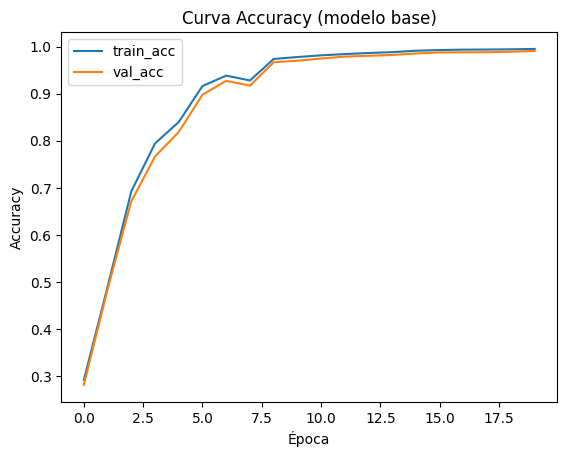

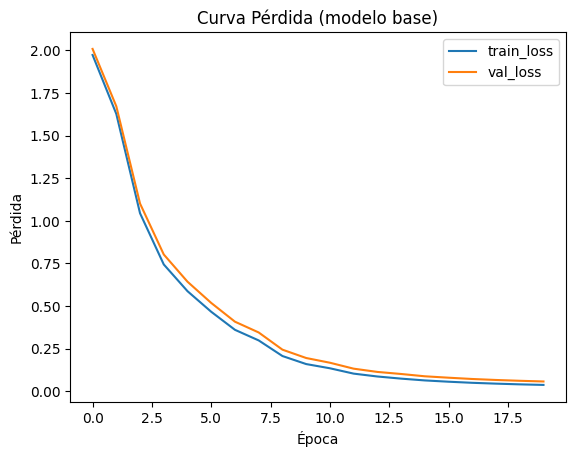

Figuras en: /content/results


In [ ]:
# ===== guardar comparación y curvas (si guardaste history antes) =====
from pathlib import Path
import matplotlib.pyplot as plt

out_dir = Path("/content/results")
out_dir.mkdir(parents=True, exist_ok=True)

df_results.to_csv(out_dir/"performance_comparison.csv", index=False)
print("Resultados guardados en:", out_dir/"performance_comparison.csv")

# Si quieres graficar la última historia 'history' del modelo base:
plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.xlabel("Época"); plt.ylabel("Accuracy"); plt.title("Curva Accuracy (modelo base)"); plt.legend()
plt.savefig(out_dir/"training_accuracy.png", bbox_inches="tight"); plt.show()

plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Época"); plt.ylabel("Pérdida"); plt.title("Curva Pérdida (modelo base)"); plt.legend()
plt.savefig(out_dir/"training_curves.png", bbox_inches="tight"); plt.show()

print("Figuras en:", out_dir)


In [1]:
import numpy as np

class NeuralNetwork:
    def __init__(self, layers, activation='relu'):
        self.layers = layers
        self.activation_name = activation
        self.params = {}
        self.cache = {}
        self.grads = {}
        self._init_weights()

    def _init_weights(self):
        for i in range(1, len(self.layers)):
            if self.activation_name == 'relu':
                factor = np.sqrt(2 / self.layers[i - 1])  # He
            else:
                factor = np.sqrt(1 / self.layers[i - 1])  # Xavier
            self.params['W' + str(i)] = np.random.randn(self.layers[i], self.layers[i - 1]) * factor
            self.params['b' + str(i)] = np.zeros((self.layers[i], 1))

    def _activation(self, Z):
        if self.activation_name == 'sigmoid':
            return 1 / (1 + np.exp(-Z))
        elif self.activation_name == 'tanh':
            return np.tanh(Z)
        return np.maximum(0, Z)

    def _activation_derivative(self, Z):
        if self.activation_name == 'sigmoid':
            A = 1 / (1 + np.exp(-Z))
            return A * (1 - A)
        elif self.activation_name == 'tanh':
            return 1 - np.tanh(Z) ** 2
        return (Z > 0).astype(float)  # ReLU

    def forward(self, X):
        A = X
        self.cache['A0'] = A
        for i in range(1, len(self.layers)):
            Z = np.dot(self.params['W' + str(i)], A) + self.params['b' + str(i)]
            A = self._activation(Z)
            self.cache['Z' + str(i)] = Z
            self.cache['A' + str(i)] = A
        return A

    def backward(self, X, Y):
        m = X.shape[1]
        L = len(self.layers) - 1
        dA = self.cache['A' + str(L)] - Y

        for i in reversed(range(1, L + 1)):
            dZ = dA * self._activation_derivative(self.cache['Z' + str(i)])
            dW = (1 / m) * np.dot(dZ, self.cache['A' + str(i - 1)].T)
            db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
            dA = np.dot(self.params['W' + str(i)].T, dZ)
            self.grads['dW' + str(i)] = dW
            self.grads['db' + str(i)] = db

    def update(self, learning_rate):
        for i in range(1, len(self.layers)):
            self.params['W' + str(i)] -= learning_rate * self.grads['dW' + str(i)]
            self.params['b' + str(i)] -= learning_rate * self.grads['db' + str(i)]

    def train(self, X, Y, epochs, learning_rate):
        for i in range(epochs):
            output = self.forward(X)
            loss = np.mean((output - Y) ** 2)
            self.backward(X, Y)
            self.update(learning_rate)
            if i % 10 == 0:
                print(f"Epoch {i}, Loss: {loss:.4f}")


In [4]:
# Simular datos: 10 usuarios, 5 películas
np.random.seed(42)
X = np.random.rand(5, 10)  # cada columna es un usuario, cada fila una película
Y = np.random.rand(1, 10)  # rating deseado (promedio, por ejemplo)

In [5]:
model = NeuralNetwork(layers=[5, 8, 4, 1], activation='relu')
model.train(X, Y, epochs=100, learning_rate=0.01)


Epoch 0, Loss: 0.2429
Epoch 10, Loss: 0.2322
Epoch 20, Loss: 0.2208
Epoch 30, Loss: 0.2096
Epoch 40, Loss: 0.2022
Epoch 50, Loss: 0.1957
Epoch 60, Loss: 0.1898
Epoch 70, Loss: 0.1843
Epoch 80, Loss: 0.1792
Epoch 90, Loss: 0.1744


In [6]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X.T, Y.T)
print("Regresión lineal:", reg.score(X.T, Y.T))


Regresión lineal: 0.17651774758419936


### Limitaciones y escalabilidad
Esta red neuronal básica funciona para datos pequeños, pero no escala bien. Para el proyecto final se necesita usar PyTorch para embeddings, múltiples entradas y manejo eficiente de datos. TensorFlow también puede permitir exportar el modelo como API. Esta versión es útil como base educativa.
